In [1]:
import json, os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imp
from tools import vis, util

# Load the data
X is the location of a vehicle at a particular time. We've used simple segmentation to give a trip ID to the vehicle too. y is a mapping from vehicle ID to user metadata.

In [3]:
with open('./processed/vast2014.json') as fp:
    obj = json.load(fp)
    X = pd.DataFrame(**obj['X'])
    X['Timestamp'] = pd.DatetimeIndex(X.Timestamp)
    X.set_index('Timestamp', inplace=True)
    
    y = pd.DataFrame(**obj['y'])

In [4]:
X.head()

,id,lat,long,trip
Timestamp,,,,
2014-01-06 06:28:01,35,36.076225,24.874689,0
2014-01-06 06:28:01,35,36.076220,24.874596,0
2014-01-06 06:28:03,35,36.076211,24.874443,0
2014-01-06 06:28:05,35,36.076217,24.874253,0
2014-01-06 06:28:06,35,36.076214,24.874167,0


In [5]:
y.head()

,CurrentEmploymentTitle,CurrentEmploymentType,FirstName,LastName
1,IT Helpdesk,Information Technology,Lucas,Alcazar
2,Engineer,Engineering,Lars,Azada
3,Engineer,Engineering,Felix,Balas
4,SVP/CFO,Executive,Ingrid,Barranco
5,IT Technician,Information Technology,Isak,Baza


# Class Distributions
Some classes just have one vehicle.

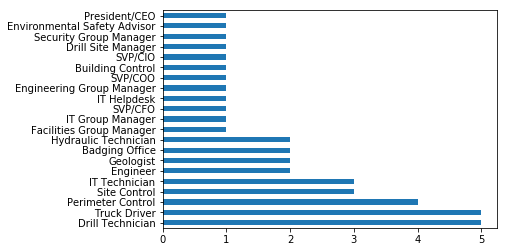

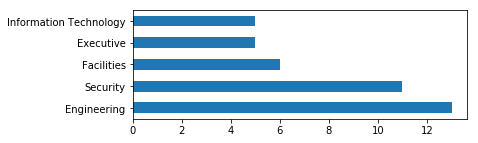

In [6]:
y.CurrentEmploymentTitle.value_counts().plot.barh(color=plt.cm.tab10(0))

plt.figure(figsize=(6,2))
y.CurrentEmploymentType.value_counts().plot.barh(color=plt.cm.tab10(0))

# Subset the data
Below we look at trajectories in a 3 day period and resamples trajectories into 30 second bins to make the analysis more tractable.

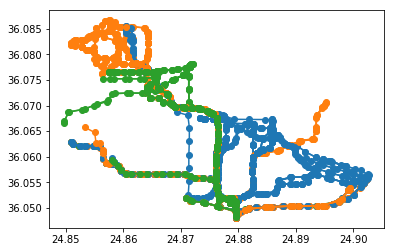

In [7]:
freq = '30s'

X_trips = X['2014-01-7':'2014-01-10'].groupby(['id', 'trip'])\
    .apply(lambda xi: xi[['long', 'lat']].resample(freq).apply(np.mean).ffill().values)
    
colors = {d: plt.cm.tab10(i)
          for i,d in enumerate(y.CurrentEmploymentType.unique())}

# draw some of the trajectories colored by employment type
# some clustering is visible.
plt.figure()
for i, Xit in X_trips.groupby(level=0):
    for xi in Xit.loc[:10]:
        d = y.CurrentEmploymentType.loc[i]
        plt.plot(*xi.T, 'o-', c=colors[d])

# Time Warping
This runs dynamic time warping (DTW) on all pairs of trajectories in the subset. DTW is a distance heuristic that is less naive than Euclidean distance for time series data.

This takes a while to calculate.

In [8]:
from scipy.spatial.distance import squareform
from itertools import combinations
from fastdtw import fastdtw

n = len(X_trips)
r = 4

def symmetric_dtw(x, y):
    # take the smallest warped distance of (x, y) and (x, reverse(y)) so that
    # backwards trajectories, e.g., trips home, look the same.
    return min(fastdtw(x, y, radius=r)[0],
               fastdtw(x, y[::-1], radius=r)[0])

D = squareform([symmetric_dtw(x, y)
                for x, y in util.iter_progress(combinations(X_trips, 2), n*(n-1)/2)])

A Jupyter Widget

# Dimension Reduction
Manifold learning (MDS) is used directly on the precomputed DTW distance matrix.

In [9]:
from sklearn.manifold import MDS

X_traj = X.set_index(['id', 'trip'])

pos = pd.DataFrame(MDS(dissimilarity='precomputed').fit_transform(D), index=X_trips.index)

# Visualization
Plot the trajectories using the same coordinate system

/Users/aren438/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


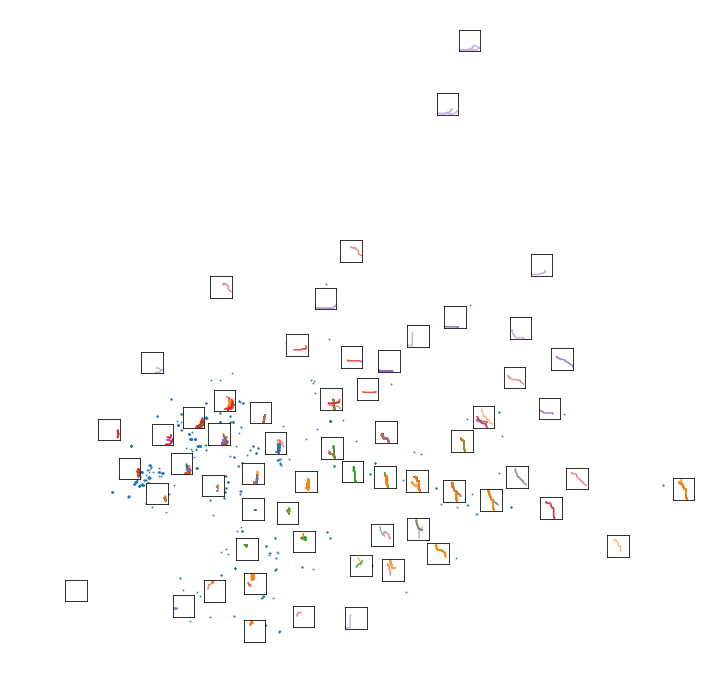

In [10]:
cols = ['long', 'lat']

xmin, xmax = 24.825, 24.909
ymin, ymax = 36.048, 36.090

plt.figure(figsize=(12, 12))
plt.axis('off')
for x, ax in vis.subplots_scatter(pos, s=.025, scatter_args=dict(s=1, alpha=.75)):
    for i in x:
        d = y.CurrentEmploymentType.loc[i[0]]
        ax.plot(*X_traj.loc[i, cols].values.T, alpha=.5, c=colors[d])

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

# Ideas for more exploration
* Data Slicing
    * Look at a single person, longitudinally (find anomalies)
    * Look at a single employment type, classfiy the person
* One-Shot Learning/Core Set Sampling
    1. Pick one example timeseries from each class
    1. build features as distances to each example
* Graph modeling
    1. Discretize space based on start and endpoints, e.g. using k-Means
    1. build a graph model of behavior of an individual within a day
    1. use dimension reduction on graphs